In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd "/content/drive/Shareddrives/CSCI5527Project"

/content/drive/Shareddrives/CSCI5527Project


In [3]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 12.0 MB/s 
     |████████████████████████████████| 512 kB 82.5 MB/s 
     |████████████████████████████████| 125 kB 70.7 MB/s 


<KeysViewHDF5 ['rates.crop']>
(2160, 1, 252, 252)
(1, 252, 252)
<class 'numpy.ndarray'>
255 0
[254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
 254 254 254 254 254 254   0   0   0   0   0   0 254 254 254 254 254 254
 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  

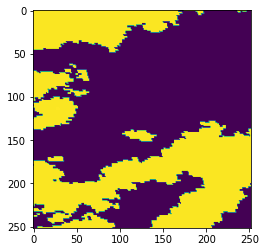

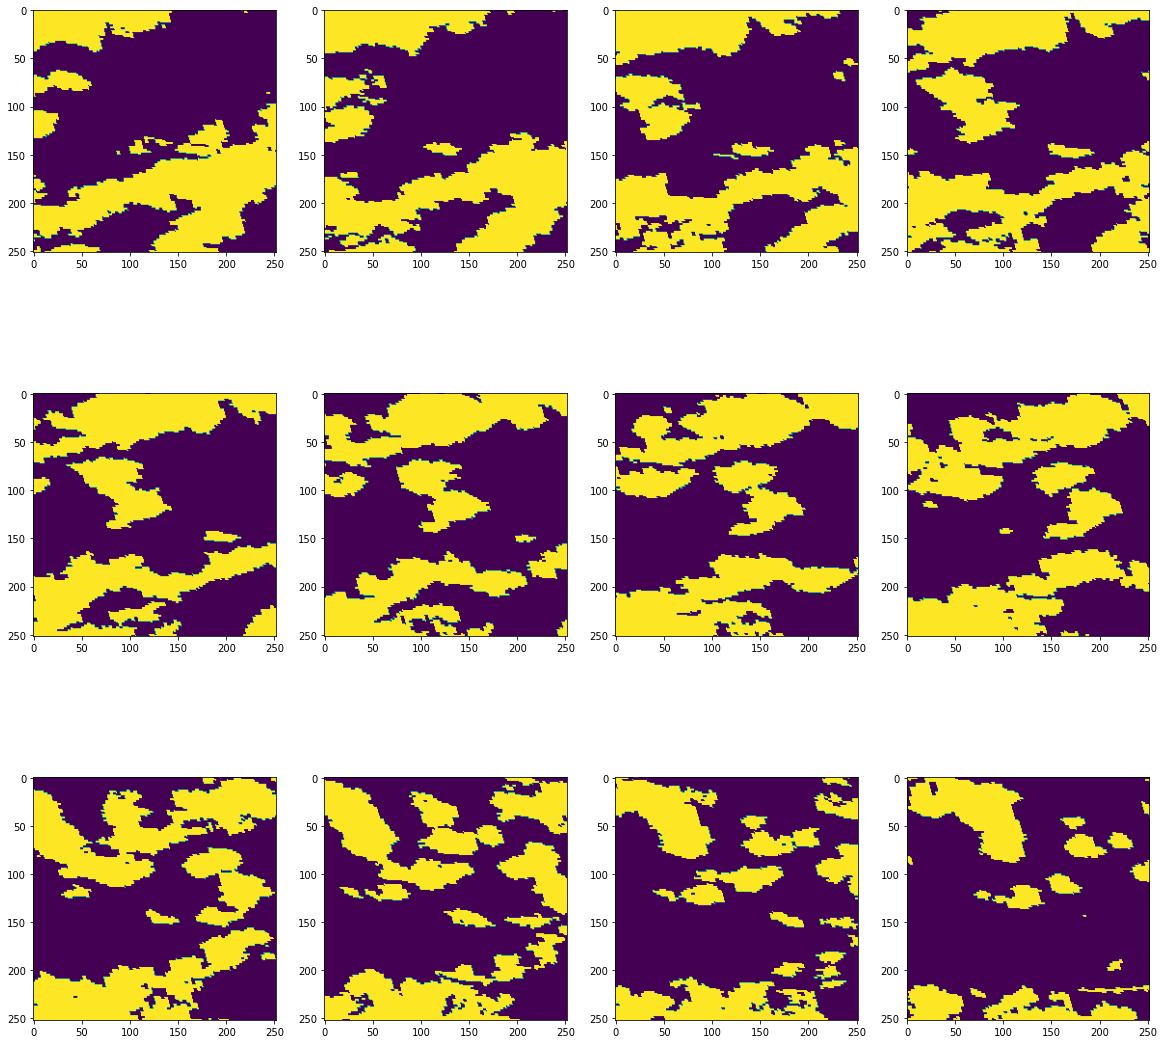

In [11]:
import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt  
from PIL import Image 
from google.colab.patches import cv2_imshow

f = h5py.File('/content/drive/Shareddrives/CSCI5527Project/data/2019/OPERA/boxi_0034.val.rates.crop.h5', 'r')

print(f.keys())
imgs = f['rates.crop']
print(imgs.shape)
print(imgs[1].shape)

img0 = imgs[1]
img0 = np.squeeze(img0)
img0 = ((img0 - img0.min()) * (1/(img0.max() - img0.min()) * 255)).astype('uint8')
#plt.imshow(((img0 - img0.min()) * (1/(img0.max() - img0.min()) * 255)).astype('uint8'))
plt.imshow(img0)
print(type(img0))
print(img0.max(), img0.min())
print(img0[0])
gt_img = Image.fromarray(img0)
gt_img.save("gt_example.jpg")

plt.subplots(3,4,figsize = (20,20))
for i in range(12):
    img_np = imgs[i]
    img_np = np.squeeze(img_np)
    plt.subplot(3,4,1+i)
    plt.imshow(img_np)
plt.show()

#visualize ground truths

<KeysViewHDF5 ['REFL-BT']>
(2160, 11, 252, 252)
(11, 252, 252)


TypeError: ignored

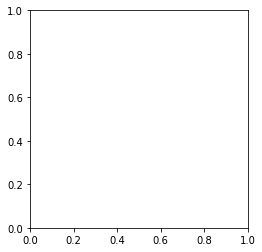

In [ ]:
valFile = h5py.File("/content/drive/Shareddrives/CSCI5527Project/data/boxi_0034.val.reflbt0.ns.h5", "r")

print(valFile.keys())
images = valFile['REFL-BT']
print(images.shape)
print(images[1].shape)
img0 = images[0]
plt.imshow(img0)

# plt.subplots(3,4,figsize = (20,20))
# for i in range(11):
#     img_np = img0[i]
#     img_np = np.squeeze(img_np)
#     plt.subplot(3,4,1+i)
#     plt.imshow(img_np)
# plt.show()

#visualize 11-band input images

In [ ]:
gt_file = h5py.File("/content/drive/Shareddrives/CSCI5527Project/data/boxi_0034.train.rates.crop.h5", "r")
train_file = h5py.File("/content/drive/Shareddrives/CSCI5527Project/data/boxi_0034.train.reflbt0.ns.h5", "r")
print(train_file.keys())
images = train_file['REFL-BT']
print(images.shape)
gt = gt_file['rates.crop']
print(gt.shape)

<KeysViewHDF5 ['REFL-BT']>
(20308, 11, 252, 252)
(20308, 1, 252, 252)


# Dataloader Code  (Won't Work)


In [ ]:
import os
import math
import numpy as np 
from PIL import Image
import cv2
from pathlib import Path
import time
import argparse
import logging 


import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()
from google.colab.patches import cv2_imshow

from tqdm.notebook import tqdm
import torch
import torch.nn as nn   #defines pre-existing set of neural networks
import torch.nn.functional as F   #defines set of functions, that pytorch knows how to autodiff
import torch.utils.data as data   
import torch.optim as optim       
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

from pathlib import Path

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

#ensure all operations are deterministic on GPU for reproducible results
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


In [ ]:
import h5py

class weatherDataset(Dataset):
    def __init__(self, img_file_path, gt_file_path, transform = None):
        self.img_file = h5py.File(img_file_path, "r")
        self.gt_file = h5py.File(gt_file_path, "r")
        self.imgs = self.img_file['REFL-BT']                    #each file is [batch_size, 11, W,H] or [batch_size, 11, H,W]      11- # of channels in data
        self.gt = self.gt_file['rates.crop']                    #[batch_size, 1, W/H, W/H]
        self.transform = transform              

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        
        img_sample = torch.from_numpy(self.imgs[index, :, :, :]).type(torch.FloatTensor)
        gt_sample = torch.from_numpy(self.gt[index, :, :, :]).type(torch.FloatTensor)

        # sample = {'image': torch.from_numpy(img_sample).type(torch.FloatTensor), 'mask':torch.from_numpy(mask_sample).type(torch.FloatTensor)}

        return img_sample, gt_sample

In [ ]:
data_file_path = "/content/drive/Shareddrives/CSCI5527Project/data/boxi_0034.val.reflbt0.ns.h5"
mask_file_path = "/content/drive/Shareddrives/CSCI5527Project/data/boxi_0034.val.rates.crop.h5"

weatherData = weatherDataset(data_file_path, mask_file_path)


In [ ]:
print(len(weatherData))

2160


# Dataloader (provided by competition)

In [10]:
#data_utils.py file
from re import VERBOSE
import numpy as np
import pandas as pd
import yaml
import h5py
import pickle
from torch.utils.data import DataLoader
import time
import torch
import os

from datetime import datetime, timedelta

VERBOSE = False
# VERBOSE = True


# __________________________________________________CREATING/LOADING SAMPLE IDS____________________________________________________


def load_sample_ids(
    data_split, splits_df, len_seq_in, len_seq_predict, regions, generate_pkl, years, path=""
):
    """For loading the sample idxs of the dataset. If a pkl file is found, it will be loaded. If not, it will be generated.
    If you want to save a .pkl file, set generate_pkl to True in the yaml file.
    Args:
        data_split (string): The data split to load the sample idxs for.
        splits_df (DataFrame): The dataframe specifying what split each timepoint belongs to. Used to generate samples
        len_seq_in (int): The length of the input sequence.
        len_seq_predict (int): The length of the prediction sequence.
        regions (list): the regions to create samples for
        generate_pkl (bool): If True, a pkl file will be generated. If False, a pkl file will be loaded.
        path (str, optional): The path to load sample idxs from. Defaults to ''.
    Returns:
        dict: A dictionary of the sample idxs.
    """
    
    print("|YEARS]", years)
    
    # if generate_pkl:
    #     idxs_r = generate_and_cache_sequences(
    #         data_split, splits_df, len_seq_in, len_seq_predict, regions, years, path
    #     )
    # # elif ".pkl" in path:  # read pre-computed (fastest)
    # #     print("load_sample_ids using pkl cache:", path)
    # #     idxs_r = read_samples_ids(path, data_split)
    # else:
    idxs_r = generate_sample_ids(
        data_split, splits_df, len_seq_in, len_seq_predict, regions, years
    )
    return idxs_r


def generate_and_cache_sequences(
    split, splits_df, len_seq_in, len_seq_predict, regions, path_name, years
):
    """Generates and saves the the sample idxs for the dataset. This generates the sample idxs for all data splits.
    Args:
        split (string): The data split to return the sample idxs for.
        splits_df (DataFrame): The dataframe specifying what split each timepoint belongs to. Used to generate samples
        len_seq_in (_type_): The length of the input sequence.
        len_seq_predict (_type_): The length of the prediction sequence.
        regions (_type_): The regions to create samples for
        path_name (_type_): The path to save the sample idxs to.
    Returns:
        list: A list of the sample idxs.
    """

    samples = {"training": [], "validation": [], "test": []}

    for data_split in ["training", "validation", "test"]:
        idxs = generate_sample_ids(
            data_split, splits_df, len_seq_in, len_seq_predict, regions, years
        )
        samples[data_split] = idxs
        if VERBOSE:
            print(f"{len(idxs)} {data_split} samples")

    qq = samples.copy()
    with open(path_name, "wb") as f:
        pickle.dump(qq, f)
    return samples[split]


def read_samples_ids(path, data_split):
    """read in sample idxs if they are already generated
    Args:
        path (String): path to pkl file with sample idxs
        data_split (String): data split to load sample idxs for
    Returns:
        list: list of sample idxs
    """
    with open(path, "rb") as f:
        loaded_dict = pickle.load(f)
        return loaded_dict[data_split]


def generate_sample_ids(data_split, splits_df, len_seq_in, len_seq_predict, regions, years):
    """generates sample idxs for a given data split
    Args:
        data_split (String): data split to load sample idxs for
        splits_df (DataFrame): the dataframe specifying what split each timepoint belongs to. Used to generate samples
        len_seq_in (int): the length of the input sequence.
        len_seq_predict (int): the length of the prediction sequence.
        regions (list): the regions to create samples for
    Returns:
        list: list of sample idxs for a specific data split
    """
    if data_split == "training":
        idxs_r = get_training_idxs(
            splits_df, len_seq_in, len_seq_predict, data_split, regions[0], years
        )
        for r in range(1, len(regions)):  # append rest of regions to df
            idxs = get_training_idxs(
                splits_df, len_seq_in, len_seq_predict, data_split, regions[r], years
            )
            idxs_r = idxs_r + idxs

    elif data_split == "validation":  # Validation/Testing/Heldout Data
        idxs_r = get_validation_idxs(
            splits_df, len_seq_in, len_seq_predict, data_split, regions[0], years
        )
        for r in range(1, len(regions)):  # append rest of regions to df
            idxs = get_validation_idxs(
                splits_df, len_seq_in, len_seq_predict, data_split, regions[r], years
            )
            idxs_r = idxs_r + idxs
    else:  # testing
        idxs_r = get_test_heldout_idxs(splits_df, len_seq_in, data_split, regions[0], years)
        for r in range(1, len(regions)):  # append rest of regions to df
            idxs = get_test_heldout_idxs(splits_df, len_seq_in, data_split, regions[r], years)
            idxs_r = idxs_r + idxs
    return idxs_r


def get_training_idxs(df, len_seq_in, len_seq_predict, data_split, region, years):
    """get sample idxs for training data split
    Args:
        df (DataFrame): _description_
        len_seq_in (int): length of input sequence
        len_seq_predict (int): length of prediction sequence
        data_split (String): data split to load sample idxs for
        region (String): region to create samples for
    Returns:
        list: list of sample idxs for training data split
    """
    idxs = []

    df = df[df['split'] == data_split]
    df = df[df['all_vars'] == 1]
    dfs= pd.DataFrame(columns = df.columns);
    
    print("years //// ", years)
    for year in years:
        dfs=pd.concat([dfs,df[df['date'].dt.year==int(year)]]);
    if VERBOSE:
        print(f"Keeping {dfs.shape[0]} {data_split} rows of {df.shape[0]} for {region} in {years}");
    df=dfs;

    # non testing
    for i in range(df.shape[0] - len_seq_in - len_seq_predict + 1):
        # date check

        s_id = df.iloc[i]["date_time_str"]
        e_id = df.iloc[i + len_seq_in + len_seq_predict - 1]["date_time_str"]

        dd1, mm1, yy1 = get_day_month_year(s_id)
        h1, m1, s1 = get_hours_minutes_seconds(s_id)
        start_dt = datetime(yy1, mm1, dd1, h1, m1, s1)

        dd2, mm2, yy2 = get_day_month_year(e_id)
        h2, m2, s2 = get_hours_minutes_seconds(e_id)
        end_dt = datetime(yy2, mm2, dd2, h2, m2, s2)

        if start_dt + timedelta(hours=8, minutes=45, seconds=0) == end_dt:
            # print(get_future_time(df.iloc[i]['time'], (len_seq_predict * 15)))
            in_seq = [i + j for j in range(len_seq_in)]
            out_seq = [i + len_seq_in + j for j in range(len_seq_predict)]
            idxs.append([in_seq, out_seq, region])

    return idxs


def get_test_heldout_idxs(df, len_seq_in, data_split, region, years):
    """get sample idxs for test data split
    Args:
        df (DataFrame): _description_
        len_seq_in (int): length of input sequence
        len_seq_predict (int): length of prediction sequence
        data_split (String): data split to load sample idxs for
        region (String): region to create samples for
    Returns:
        list: list of sample idxs for test data split
    """
    idxs = []

    split_type = f"{data_split}_in"
    df = df[df["split_type"] == split_type]
    df = df[df["all_vars"] == 1]
    dfs= pd.DataFrame(columns = df.columns);
    for year in years:
        dfs=pd.concat([dfs,df[df['date'].dt.year==int(year)]]);
    if VERBOSE:
        print(f"Keeping {dfs.shape[0]} {data_split} rows of {df.shape[0]} for {region} in {years}");
    df=dfs;


    for start_index in range(0, df.shape[0], len_seq_in):
        in_seq = [start_index + i for i in range(len_seq_in)]
        test_seq = [in_seq, [], region]
        idxs.append(test_seq)
    return idxs


def get_validation_idxs(df, len_seq_in, len_seq_out, data_split, region, years):
    """get sample idxs for validation data split
    Args:
        df (DataFrame): timepoint dataframe
        len_seq_in (int): length of input sequence
        len_seq_predict (int): length of prediction sequence
        data_split (String): data split to load sample idxs for
        region (String): region to create samples for
    Returns:
        list: list of sample idxs for validation data split
    """
    idxs = []
    split_type = f"{data_split}_in"
    df = df[df["split"] == data_split]
    df = df[df["all_vars"] == 1]
    dfs= pd.DataFrame(columns = df.columns);
    for year in years:
        dfs=pd.concat([dfs,df[df['date'].dt.year==int(year)]]);
    if VERBOSE:
        print(f"Keeping {dfs.shape[0]} {data_split} rows of {df.shape[0]} for {region} in {years}");
    df=dfs;
    
    for i in range(df.shape[0]):
        if df.iloc[i]["split_type"] == split_type:
            input_output_seq = get_io_validation_times(
                df, i, len_seq_in, len_seq_out, region
            )
            if input_output_seq:
                idxs.append(input_output_seq)
    return idxs


def get_io_validation_times(df, start_index, len_seq_in, len_seq_predict, region):
    """get input and output times for validation data split. Checks for valid sequences
    Args:
        df (int): timepoint dataframe
        start_index (int): startng index of sequence
        len_seq_in (int): length of input sequence
        len_seq_predict (int): length of prediction sequence
        region (String): region to create sequences for
    Returns:
        list: list of input, output times and region for validation data split
    """
    split_type_in = f"validation_in"
    end_index = start_index + len_seq_in + len_seq_predict - 1
    if end_index < len(df):
        seq = df[start_index:end_index]
        in_seq = seq[:len_seq_in]
        out_seq = seq[len_seq_in:]
        # check all input is of the same type
        if len(in_seq[in_seq["split_type"] == split_type_in]) != len(in_seq):
            return []
        # convert input/output sequence to lists and return
        else:
            in_seq = [start_index + i for i in range(len_seq_in)]
            out_seq = [start_index + len_seq_in + i for i in range(len_seq_predict)]
            return [in_seq, out_seq, region]
    else:
        return []


# ______________________________________LOADING DATA_______________________________________


def load_dataset(root, data_split, regions, years, product):
    """load dataset from root folder and return as list
    Args:
        root (String): root folder to load dataset from
        data_split (String): data split to load dataset for
        regions (list): list of regions to load dataset for
        product (String): product to load dataset for e.g. satellite or radar
    Returns:
        list : full dataset
    """
    dataset = {}
    if data_split == "validation":
        data_split = "val"
    elif data_split == "training":
        data_split = "train"
        
    if VERBOSE:
        print(f"Data split {data_split}")
        print(f"Regions {regions}")
        print(f"Years {years}")
        print(f"Product {product}")
    
    for region in regions:
        if VERBOSE: print(f"Region: {region}")
        yearly_records = {}
        for year in years:
            if VERBOSE: print(f"Year: {year}")
            if product == "RATE":
                file = f"{region}.{data_split}.rates.crop.h5"
                path = f"{root}/{year}/OPERA/{file}"
                f = h5py.File(path, "r")
                ds = f["rates.crop"]
                yearly_records[year] = ds
                # f.close()
            else:
                file = f"{region}.{data_split}.reflbt0.ns.h5"
                path = f"{root}/{year}/HRIT/{file}"
                f = h5py.File(path, "r")
                ds = f["REFL-BT"]
                yearly_records[year]  = ds
                # f.close()
                # close file memory leak?
                # when done reading, close files?
                
        if VERBOSE: print(f"Done reading {region}... skipping concatenation")
        dataset[region] = yearly_records
        
    if VERBOSE: print(f"{data_split} Data read ... returning to dataset.)")
    if VERBOSE: print(f"Read {len(dataset)} regions, with each containing {len(dataset[list(dataset.keys())[0]])} years.")
    return dataset 


def get_sequence(
    seq,
    root,
    data_split,
    region,
    product,
    bands,
    preprocess=None,
    swap_time_ch=False,
    ds=None,
):
    """get data and metadata for a given sequence.
    Args:
        seq (list): list containing sequence of idxs to be retrieved
        root (String): root for data
        data_split (String): data split to load sequence for
        region (String): region to load sequence for
        product (String): product to load sequence for e.g. satellite or radar
        bands (list): list of bands to load sequence for
        preprocess (list, optional): preprocessing settings. Defaults to None.
        swap_time_ch (bool, optional): swap time and channel axis if set to True. Defaults to False.
        ds (numpy array, optional): full dataset to read from. Defaults to None.
    Returns:
        prod_seq: sequence of data and metadata
        mask_seq: corresponding sequence of masks
    """

    prod_seq = []
    mask_seq = []
    for s in seq:
        prods, masks = get_file(
            s, root, data_split, region, product, bands, preprocess, ds
        )
        prod_seq.append(prods)
        mask_seq.append(masks)
    # return format - time x channels x width x height
    mask_seq = np.asarray(mask_seq)

    # Swapping Axes to give shape  channels x time x width x height
    if swap_time_ch:
        prod_seq = np.swapaxes(prod_seq, 0, 1)
        mask_seq = np.swapaxes(mask_seq, 0, 1)
    return np.array(prod_seq), mask_seq


def get_file(
    sample_id, root, data_split, region, product, bands, preprocess=None, ds=None
):
    """Read/Preprocess data and metadata for single timepoint.
    Args:
        sample_id (int): idx to be retrieved
        root (String): root for data
        data_split (String): data split to load data point for
        region (String): region to load data point for
        product (String): product to load data point for e.g. satellite or radar
        bands (list): satellite bands to load data point for
        preprocess (list, optional): preprocessing settings. Defaults to None.
        ds (numpy array, optional): full dataset to read from. Defaults to None.
    Returns:
        x(numpy array): data for single timepoint
        masks(numpy array): masks for single timepoint
    """

    if VERBOSE:
        print("\n", "_____________READING FILE_________________________")
        file_t = time.time()
    # Get file containing all neede channels for a given time - (1xCxWxH)
    prods = []
    masks = []

    x = read_file(sample_id, ds, region)
    x = np.float32(x)
    if VERBOSE:
        print(time.time() - file_t, "reading file time")
    if product == "RATE":
        for b in ["rainfall_rate-500X500"]:
            # if preprocess:
            if preprocess[product][b]["mask"]:
                mask = create_mask(x, preprocess[product][b]["mask"])
                masks.append(mask)
                masks = masks[0]
            if preprocess is not None:
                x = preprocess_OPERA(x, preprocess[product][b])
            if VERBOSE:
                print(time.time() - file_t, "OPERA preprocess time")
    else:
        for j, b in enumerate(bands):
            if preprocess is not None:
                x[j] = preprocess_HRIT(x[j], preprocess[b])
            if VERBOSE:
                print(time.time() - file_t, "HRIT preprocess time")

    # return format - channels x width x height
    if VERBOSE:
        print(time.time() - file_t, "Total File Read Time")
    return x, masks


def read_file(sample_id, ds, region):
    previous_year_samples = 0
    for year in ds[region]:
        # print(sample_id, previous_year_samples)
        i = sample_id - previous_year_samples;
        if i < len(ds[region][year]):
            return ds[region][year][i]
        previous_year_samples += len(ds[region][year])
    
    raise Exception(f"Sample {sample_id} not found for {region}")

# ___________________PREPROCESSING FUNCTIONS_______________________________________


def crop_numpy(x, crop):
    """crop numpy array
    Args:
        x (numpy array): array to be cropped
        crop (int): crop size
    Returns:
        data(numpy array): cropped array
    """
    return x[:, :, crop:-crop, crop:-crop]


def preprocess_fn(x, preprocess, verbose=False):
    """Funciton to precprocess data
        Assumption: the mask has been previously created (otherwise won't be recovered)
        # 1. map values
        # 2. clip values out of range
    Args:
        x (numpy array): data to be preprocessed
        preprocess (list): preprocessing settings
        verbose (bool, optional): verbose preprocessing. Defaults to False.
    Returns:
        data(numpy array): preprocessed data
    """

    if verbose:
        print(0, np.unique(x))
    # 1 Map values
    for q, v in preprocess["map"]:

        if isinstance(q, str):
            if q == "nan":
                x[np.isnan(x)] = v
            elif q == "inf":
                x[np.isinf(x)] = v
            elif "greaterthan" in q:
                greater_v = float(q.partition("greaterthan")[2])
                x[x > greater_v] = v
            elif "lessthan" in q:
                less_v = float(q.partition("lessthan")[2])
                x[x < less_v] = v
        else:
            x[x == q] = v
    if verbose:
        print(1, np.unique(x, return_counts=True))

    # 2 Clip values out of range
    m, M = preprocess["range"]
    x[x < m] = m
    x[x > M] = M
    if verbose:
        print(2, np.unique(x, return_counts=True))

    return x, M


def preprocess_HRIT(x, preprocess, verbose=False):
    """Preprocess HRIT data - standardize data, map values, clip values out of range
        Assumption: the mask has been previously created (otherwise won't be recovered)
    Args:
        x (numpy array): data to be preprocessed
        preprocess (list): preprocessing settings
        verbose (bool, optional): verbose preprocessing. Defaults to False.
    Returns:
        x(list): preprocessed data
    """
    # 1, 2
    if verbose:
        print("HRIT file:")
    x, M = preprocess_fn(x, preprocess, verbose=verbose)

    # 3 - mean_std - standardisation
    if preprocess["standardise"]:
        # x = x/M
        mean, stdev = preprocess["mean_std"]
        x = x - mean
        x = x / stdev
    if verbose:
        print(3, np.uniquze(x, return_counts=True))
    return x


def preprocess_OPERA(x, preprocess, verbose=False):
    """Precprocess OPERA data - standardize data, map values, clip values out of range
        Assumption: the mask has been previously created (otherwise won't be recovered)
        # 1. map values
        # 2. clip values out of range
    Args:
        x (numpy array): data to be preprocessed
        preprocess (list): preprocessing settings
        verbose (bool, optional): verbose preprocessing. Defaults to False.
    Returns:
        x(numpy array): preprocessed data
    """
    # 1, 2
    if verbose:
        print("OPERA file:")
    x, M = preprocess_fn(x, preprocess, verbose=verbose)

    # 3 - mean_std - standardisation
    if preprocess["standardise"]:
        mean, stdev = preprocess["mean_std"]
        x = x - mean
        x = x / stdev
    if preprocess["bin"]:
        bins = np.arange(0, 128, 0.2)
        x = np.digitize(x, bins)
    if verbose:
        print(3, np.unique(x, return_counts=True))
    return x


# __________________________________GENERAL HELPER FUNCTIONS__________________________________


def standardise_time_strings(time):
    if len(time) < 6:
        time = time.rjust(6, "0")
    else:
        return time
    return time


def get_hours_minutes_seconds(date_time_str):
    h = date_time_str[9:11]
    m = date_time_str[11:13]
    s = date_time_str[13:15]
    return int(h), int(m), int(s)


def get_day_month_year(date_time_str):
    yy = date_time_str[0:4]
    mm = date_time_str[4:6]
    dd = date_time_str[6:8]
    return int(dd), int(mm), int(yy)


def time_2_channels(w, height, width):
    """collapse time dimension into channels - (B, C, T, H, W) -> (B, C*T, H, W)
    Args:
        w (numpy array): data
        height (int): image height in pixels
        width (int): image width in pixels
    Returns:
        w(numpy array): data with time dimension collapsed into channels
    """
    w = np.reshape(w, (-1, height, width))
    return w


def channels_2_time(w, seq_time_bins, n_channels, height, width):
    """Recover time dimension from channels - (B, C*T, H, W) -> (B, T, C, H, W)
    Args:
        w (numpy array): data
        seq_time_bins (_type_): number of time bins
        n_channels (int): number of channels
        height (int): image height in pixels
        width (int):  image width in pixels
    Returns:
        _type_: _description_
    """
    w = np.reshape(w, (seq_time_bins, n_channels, height, width))
    return w


def load_timestamps(
    path, types={"time": "str", "date_str": "str", "split_type": "str"}
):
    """load timestamps from a from csv file
    Args:
        path (String): path to the csv file
        types (dict, optional): types to cast columns of dataframe to. Defaults to {'time': 'str', 'date_str': 'str', 'split_type': 'str'}.
    Returns:
        Dataframe: dataframe with timestamps
    """

    df = pd.read_csv(path, index_col=False, dtype=types)

    df.sort_values(by=["date_str", "time"], inplace=True)

    # to datetime type
    df["date"] = pd.to_datetime(df["date"])

    # convert times to strings
    df["time"] = df["time"].astype(str)
    df["time"] = df["time"].apply(standardise_time_strings)

    df["date_str"] = df["date_str"].astype(str)
    # create date_time string
    df["date_time_str"] = df["date_str"] + "T" + df["time"]

    return df


def load_config(config_path):
    """Load confgiuration file
    Args:
        config_path (String): path to configuration file
    Returns:
        dict: configuration file
    """
    with open(config_path) as file:
        config = yaml.safe_load(file)
    return config


def create_mask(data, mask_values, verbose=False):
    """Create a mask from a data array and a list of values to mask out
        - " 1's indicate (any kind of) missing value
    Args:
        data (numpy array): data to be masked
        mask_values (list): list of values to mask out
        verbose (bool, optional): verbose preprocessing. Defaults to False.
    Returns:
        mask(numpy array): array of mask corresponding to the data
    """

    mask = np.full(data.shape, False, dtype=bool)
    for m in mask_values:
        if isinstance(m, str):
            if m == "nan":
                filter = np.isnan(data)
            elif m == "inf":
                filter = np.isinf(data)
            elif "max" in m:
                max_v = int(m.partition("max")[2])
                filter = data > max_v
            elif "range" in m:
                range = m.partition("range")
                l = float(range[0])
                h = float(range[2])
                filter = (data >= l) & (data < h)
        else:
            filter = data == m
        mask = np.logical_or(mask, filter)

    if verbose:
        n_missing = np.unique(filter, return_counts=True)
        print("-----> total masked values:", n_missing, "\n")
    return mask


def get_mean_std(dataset, batch_size=10):
    """Get the mean and stdev of the different image bands
    Args:
        times (list): timepoints to get mean from
        batch_size (int, optional): batch size for dataloader. Defaults to 1000.
    Returns:
        mean (list): list of band means
        stdev (list): list of band stdevs
    """
    loader = DataLoader(dataset, batch_size=batch_size)
    nimages = 0
    mean = 0
    std = 0
    count = 0
    for batch, _, _ in loader:
        print(count)
        count += 1
        # Rearrange batch to be the shape of [B, C, T * W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)

        # Compute mean of T * W * H
        # Sum over samples
        mean += batch.mean(2).sum(0)
        std += batch.std(2).sum(0)
    # Final step - divide by number of images to get average of each band
    mean /= nimages
    std /= nimages
    print(np.array(mean))
    return mean, std


def get_mean_std_opera(dataset, batch_size=10):
    """Get the mean and stdev of the different image bands
    Args:
        times (list): timepoints to get mean from
        batch_size (int, optional): batch size for dataloader. Defaults to 1000.
    Returns:
        mean (list): list of band means
        stdev (list): list of band stdevs
    """
    loader = DataLoader(dataset, batch_size=batch_size)
    nimages = 0
    mean = 0.0
    std = 0.0
    count = 0
    for _, _, metadata in loader:
        print(count)
        count += 1
        batch = metadata["OPERA_input"]["data"]
        # Rearrange batch to be the shape of [B, C, T * W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)

        # Compute mean of T * W * H
        # Sum over samples
        mean += batch.mean(2).sum(0)
        std += batch.std(2).sum(0)

    # Final step - divide by number of images to get average of each band
    mean /= nimages
    std /= nimages

    return mean, std


# ------------------------------------- GPU Functions------------------------------------------


def get_cuda_memory_usage(gpus):
    """Get the GPU memory usage
    Args:
        gpus (list): list of GPUs
    """
    for gpu in gpus:
        r = torch.cuda.memory_reserved(gpu)
        a = torch.cuda.memory_allocated(gpu)
        f = r - a  # free inside reserved
        print("GPU", gpu, "CUDA memory reserved:", r, "allocated:", a, "free:", f)


# --------------------------------------- Crop files--------------------------------------------


def crop_xarray(product, x_start, y_start, size):
    """Crop an xarray dataset
        - crop a squared region size
        - provide upper-left corner with (x_start, y_start)
    Args:
        product (xarray dataset): dataset to crop
        x_start (int): x start coordinate
        y_start (int): y start coordinate
        size (int): size of the crop
    Returns:
        xarray dataset: cropped dataset
    """
    return product.isel(
        x=slice(x_start, x_start + size), y=slice(y_start, y_start + size)
    )


def prepare_crop(location, opera_k=1):
    """prepare the crop for both context and region of interest (roi)"""

    position = np.asarray(location["up_left"])
    context, roi = location["context"], location["roi"]

    # scale if opera
    if opera_k != 1:
        context, roi, position = [opera_k * s for s in [context, roi, position]]
    context_size = context + roi + context

    context_shape = {
        "x_start": position[0],
        "y_start": position[1],
        "size": context_size,
    }
    position = position + context
    roi_shape = {"x_start": position[0], "y_start": position[1], "size": roi}
    return context_shape, roi_shape

    # --------------------------------------- Save predictions --------------------------------------------


def tensor_to_submission_file(predictions, predict_params):
    """saves prediction tesnor to submission .h5 file
    Args:
        predictions (numpy array): data cube of predictions
        predict_params (dict): dictionary of parameters for prediction
    """
    
    path = os.path.join(predict_params["submission_out_dir"],
                        str(predict_params["year_to_predict"]))
    if not os.path.exists(path):
        os.makedirs(path)
    
    submission_file_name = predict_params["region_to_predict"] + ".pred.h5"
    submission_path = os.path.join(path, submission_file_name)
    h5f = h5py.File(submission_path, "w")
    h5f.create_dataset("submission", data=predictions.squeeze())
    h5f.close()

In [ ]:
import numpy as np
from torch.utils.data import Dataset
import os
import sys
import time
from timeit import default_timer as timer

#from utils.data_utils import *

# folder to load config file
# CONFIG_PATH = "../"

# VERBOSE = True
VERBOSE = False

"""
Assumptions: 
- the data is already cropped to the right dimensions 
- Data format - [Samples, C, T, W, H] 
"""


class RainData(Dataset):
    def __init__(
        self,
        data_split,
        project_root="",
        data_root="",
        input_product="REFL-BT",
        compute_seq=True,
        output_product="RATE",
        sat_bands=[],
        preprocess_OPERA=None,
        size_target_center=None,
        full_opera_context=None,
        preprocess_HRIT=None,
        path_to_sample_ids="",
        len_seq_in=4,
        len_seq_predict=32,
        regions=["boxi_0015"],
        regions_def={},
        generate_samples=False,
        latlon_path="",
        altitudes_path="",
        #splits_path=None,
        splits_path = "/content/drive/Shareddrives/CSCI5527Project/data/2019/timestamps_and_splits_2019.csv",
        swap_time_ch=False,
        years=None,
        **kwargs
    ):
        start = timer()
        # Data Dimensions
        self.len_seq_in = len_seq_in
        self.len_seq_predict = len_seq_predict
        self.channel_dim = 1  # where to concat channels in structure

        # type of data & processing variables
        self.sat_bands = sat_bands
        self.regions = regions
        self.input_product = input_product
        self.output_product = output_product
        self.preprocess_target = preprocess_OPERA
        self.size_target_center = size_target_center
        self.full_opera_context = full_opera_context
        self.crop = int(
            (self.full_opera_context - self.size_target_center) / 2
        )  # calculate centre of image to begin crop
        self.preprocess_input = preprocess_HRIT
        self.path_to_sample_ids = path_to_sample_ids
        self.regions_def = regions_def
        self.generate_samples = generate_samples
        self.path_to_sample_ids = path_to_sample_ids
        self.swap_time_ch = swap_time_ch
        self.years = years

        # data splits to load (training/validation/test)
        self.root = project_root
        self.data_root = data_root
        self.data_split = data_split
        self.splits_df = load_timestamps(splits_path)
        # prepare all elements to load - sample idx will use the object 'self.idx'
        self.idxs = load_sample_ids(
            self.data_split,
            self.splits_df,
            self.len_seq_in,
            self.len_seq_predict,
            self.regions,
            self.generate_samples,
            self.years,
            self.path_to_sample_ids
        )

        # LOAD DATASET
        self.in_ds = load_dataset(
            self.data_root, self.data_split, self.regions, years, self.input_product
        )
        if self.data_split not in ["test", "heldout"]:
            self.out_ds = load_dataset(
                self.data_root, self.data_split, self.regions, years, self.output_product
            )
        else:
            self.out_ds = []

    def __len__(self):
        """total number of samples (sequences of in:4-out:1 in our case) to train"""
        # print(len(self.idxs), "-------------------", self.data_split)
        return len(self.idxs)

    def load_in(self, in_seq, seq_r, metadata, loaded_input=False):
        in0 = time.time()
        input_data, in_masks = get_sequence(
            in_seq,
            self.data_root,
            self.data_split,
            seq_r,
            self.input_product,
            self.sat_bands,
            self.preprocess_input,
            self.swap_time_ch,
            self.in_ds,
        )

        if VERBOSE:
            print(np.shape(input_data), time.time() - in0, "in sequence time")
        return input_data, metadata

    def load_out(self, out_seq, seq_r, metadata):
        t1 = time.time()
        # GROUND TRUTH (OUTPUT)
        if self.data_split not in ["test", "heldout"]:
            output_data, out_masks = get_sequence(
                out_seq,
                self.data_root,
                self.data_split,
                seq_r,
                self.output_product,
                [],
                self.preprocess_target,
                self.swap_time_ch,
                self.out_ds,
            )

            # collapse time to channels
            metadata["target"]["mask"] = out_masks
        else:  # Just return [] if its test/heldout data
            output_data = np.array([])
        if VERBOSE:
            print(time.time() - t1, "out sequence")
        return output_data, metadata

    def load_in_out(self, in_seq, out_seq=None, seq_r=None):
        metadata = {
            "input": {"mask": [], "timestamps": in_seq},
            "target": {"mask": [], "timestamps": out_seq},
        }

        t0 = time.time()
        input_data, metadata = self.load_in(in_seq, seq_r, metadata)
        output_data, metadata = self.load_out(out_seq, seq_r, metadata)

        if VERBOSE:
            print(time.time() - t0, "seconds")
        return input_data, output_data, metadata

    def __getitem__(self, idx):
        """load 1 sequence (1 sample)"""
        in_seq = self.idxs[idx][0]
        out_seq = self.idxs[idx][1]
        seq_r = self.idxs[idx][2]
# #        print("=== DEBUG in_seq: ",in_seq, file=sys.stderr);
#         print("=== DEBUG in_seq: ",in_seq);
        return self.load_in_out(in_seq, out_seq, seq_r)

In [ ]:
data_split = "training"            #train or val
data_root = "/content/drive/Shareddrives/CSCI5527Project/data"
regions = ["boxi_0015", "boxi_0034"]      #names of the regions
years = ["2019"]
product = ""      #('RATE' or blank)
splits_path = "/content/drive/Shareddrives/CSCI5527Project/data/2019/timestamps_and_splits_2019.csv"
# preprocess_OPERA = [
#         {
#             "rainfall_rate-500X500": 
#             [
#                 {mask: [-9999000.0, inf, nan, max128]},
#                 {map: [[lessthan0.0, 0], [greaterthan0.0, 1], [-8888000.0, 0], [-9999000.0, 0], [inf, 0], [nan, 0]]},
#                 {mean_std: [0.07165331, 0.6302647]},
#                 {range: [0, 128]},
#                 {standardise: False},
#                 {bin: False}
#             ]
#         }
# ]    

# [{
#         mask: [-9999000.0, inf, nan, max128], #, 0range0.1] # Mostly used for loss function: values added here are added to a mask and not used for loss
#         map: [[lessthan0.0, 0], [greaterthan0.0, 1], [-8888000.0, 0], [-9999000.0, 0], [inf, 0], [nan, 0]],   #Mostly used for input preprocessing   # 1. map values   # stage-1
#         mean_std: [0.07165331, 0.6302647],
#         range: [0, 128],          # 2. we evaluate only pixels in this range
#         standardise: False,       # 3. use log(x+1) instead & normalize (x/max)
#         bin: False }]


#weatherDataset = RainData(data_split=data_split, data_root = data_root, size_target_center=252, full_opera_context=1512, splits_path=splits_path, years = years, product = product, regions = regions)

In [ ]:
import pytorch_lightning as pl

class DataModule(pl.LightningDataModule):
    """ Class to handle training/validation splits in a single object
    """
    def __init__(self, params, training_params, mode):
        super().__init__()
        self.params = params     
        self.training_params = training_params
        if mode in ['train']:
            print("Loading TRAINING/VALIDATION dataset -- as test")
            self.train_ds = RainData('training', **self.params)
            self.val_ds = RainData('validation', **self.params)
            print(f"Training dataset size: {len(self.train_ds)}")
        if mode in ['val']:
            print("Loading VALIDATION dataset -- as test")
            self.val_ds = RainData('validation', **self.params)  
        if mode in ['predict']:    
            print("Loading PREDICTION/TEST dataset -- as test")
            self.test_ds = RainData('test', **self.params)
        if mode in ['heldout']:    
            print("Loading HELD-OUT dataset -- as test")
            self.test_ds = RainData('heldout', **self.params)   

    def __load_dataloader(self, dataset, shuffle=True, pin=True):
        dl = DataLoader(dataset, 
                        batch_size=self.training_params['batch_size'],
                        num_workers=self.training_params['n_workers'],
                        shuffle=shuffle, 
                        pin_memory=pin, prefetch_factor=2,
                        persistent_workers=False)
        return dl
    
    def train_dataloader(self):
        return self.__load_dataloader(self.train_ds, shuffle=True, pin=True)
    
    def val_dataloader(self):
        return self.__load_dataloader(self.val_ds, shuffle=False, pin=True)

    def test_dataloader(self):
        return self.__load_dataloader(self.test_ds, shuffle=False, pin=True)


In [ ]:
import yaml

with open(r'/content/drive/Shareddrives/CSCI5527Project/data/2019/config_baseline_stage1.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    config = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
print(config["dataset"]["preprocess_OPERA"]["RATE"])

{'rainfall_rate-500X500': {'mask': [-9999000.0, 'inf', 'nan', 'max128'], 'map': [['lessthan0.0', 0], ['greaterthan0.0', 1], [-8888000.0, 0], [-9999000.0, 0], ['inf', 0], ['nan', 0]], 'mean_std': [0.07165331, 0.6302647], 'range': [0, 128], 'standardise': False, 'bin': False}}


In [ ]:
#OPERA_preprocess = config
mode = 'train'
weatherData = DataModule(config['dataset'], config['train'], mode)

Loading TRAINING/VALIDATION dataset -- as test
|YEARS] ['2019']
years ////  ['2019']
years ////  ['2019']
|YEARS] ['2019']
Training dataset size: 28900


3
torch.Size([4, 4, 11, 252, 252])
torch.Size([4, 32, 1, 252, 252])



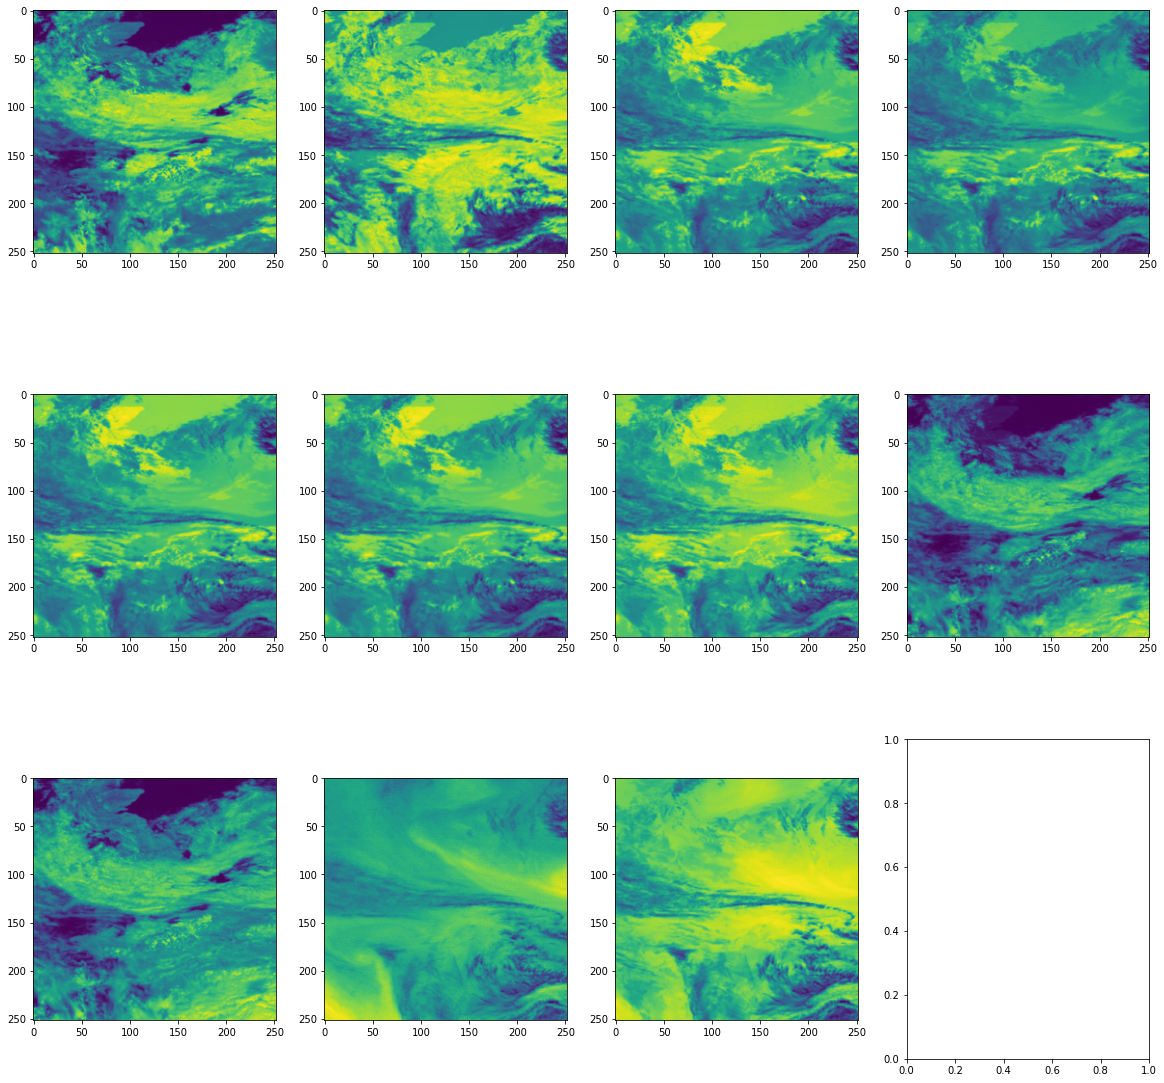

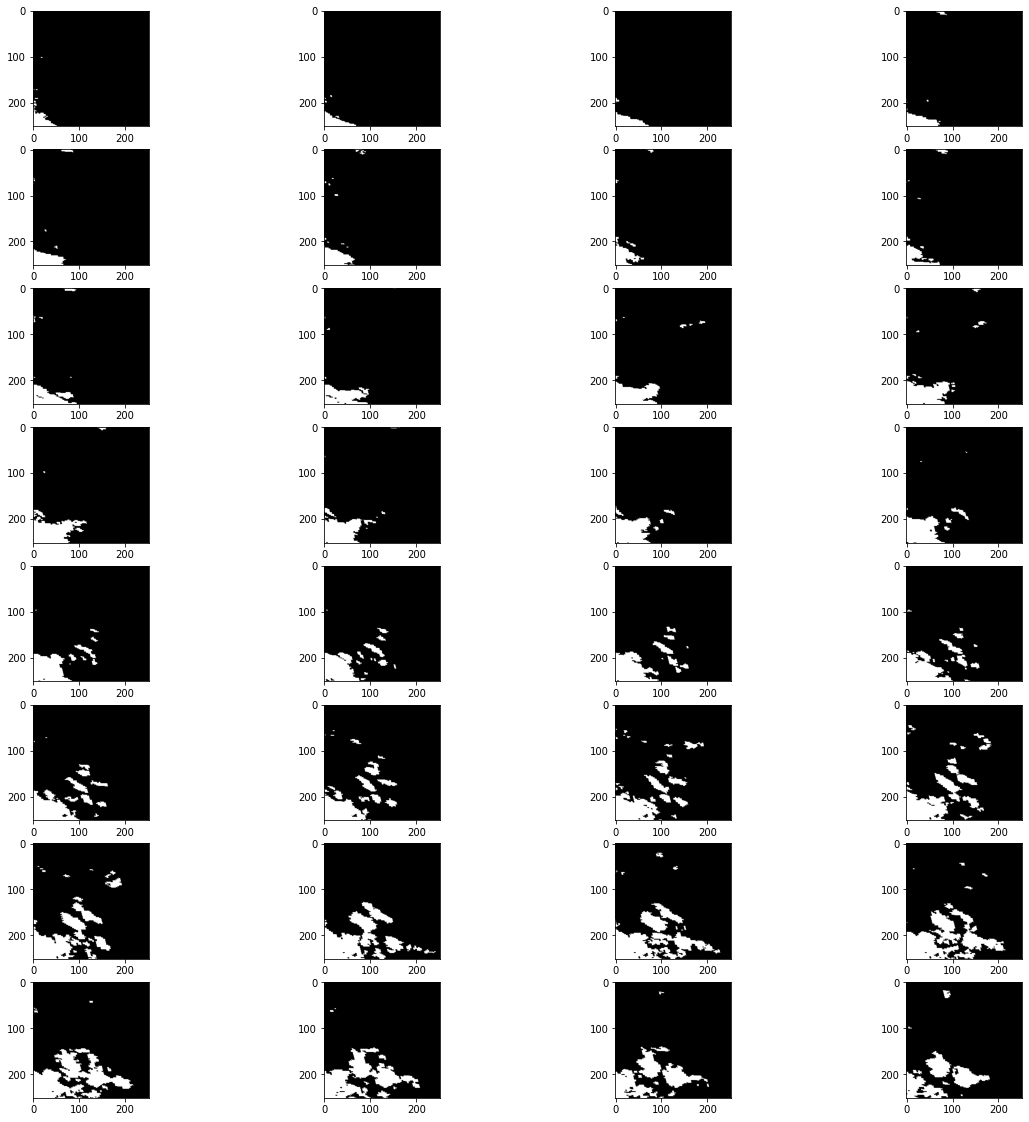

In [ ]:
#print(len(weatherDataset))
#print(len(weatherDataset[0]))
#for i in range(1):   #len(weatherDataset)):
#img = weatherDataset[0][0]
# gt = weatherDataset[0][1]
# # print(weatherDataset[i][0])
# # print(weatherDataset[i][1])
# plt.imshow(img[0][6] - img[0][4])
#print(img.shape)

weatherDataloader = weatherData.train_dataloader()
#print(len(imgs))

for ind, data in enumerate(weatherDataloader):

    print(len(data))
    inputs, gt, c = data
    print(inputs.shape)
    print(gt.shape)
    #print(c.shape)
    plt.subplots(3,4,figsize = (20,20))
    for i in range(11):
        img_np = inputs[0][0][i]
        #print(img_np.shape)
        img_np = np.squeeze(img_np)
        plt.subplot(3,4,1+i)
        plt.imshow(img_np)

    print() 

    plt.show()
    plt.subplots(8,4,figsize = (20,20))
    for i in range(32):
        img_np = gt[2][i]
        img_np = np.squeeze(img_np)
        plt.subplot(8,4,1+i)
        plt.imshow(img_np, cmap='gray')
    plt.show()

    if ind >= 0:
        break
# inputs, gt = next(iter(weatherDataloader))
# # sample, gt = weatherDataloader[0][0], weatherDataloader[0][1]

# plt.subplots(3,4,figsize = (20,20))
# for i in range(11):
#     img_np = inputs[i]
#     img_np = np.squeeze(img_np)
#     plt.subplot(3,4,1+i)
#     plt.imshow(img_np)
# plt.show()

In [ ]:
gt = weatherDataset[0][1]
print(gt.shape)

print(gt.shape[])
# plt.subplots(8,4,figsize = (20,20))
# for i in range(32):
#     img_np = gt[i]
#     img_np = np.squeeze(img_np)
#     plt.subplot(8,4,1+i)
#     plt.imshow(img_np)
# plt.show()

(32, 1, 252, 252)
32


# Conv Encoder

In [ ]:
# A = torch.rand(2, 4, 11, 252, 252) 
# gt size = torch.Size([4, 32, 1, 252, 252])

input = torch.rand(4, 4, 11, 252, 252)
#want to downsample to (4,4,11,42,42)

#downsample before concatenating the prediction masks (condition time)


class Preprocess(nn.Module):
    def __init__(
        self,
        sat_channels: int = 11,
        # crop_size: int = 256,
        # use_space2depth: bool = True,
        # split_input: bool = True,
    ):
        """
        Performs the MetNet preprocessing of mean pooling Sat channels, followed by
        concatenating the center crop and mean pool
        In the paper, the radar data is space2depth'd, while satellite channel is mean pooled, but for this different
        task, we choose to do either option for satellites
        Args:
            sat_channels: Number of satellite channels
            crop_size: Center crop size
            use_space2depth: Whether to use space2depth on satellite channels, or mean pooling, like in paper
        """
        super().__init__()
        self.sat_channels = sat_channels
        self.split_input = split_input

        # Split off sat + mask channels into own image, and the rest, which we just take a center crop
        # For this,
        self.sat_downsample = (
            torch.nn.PixelUnshuffle(downscale_factor=2)
            if use_space2depth
            else torch.nn.AvgPool3d(kernel_size=(1, 2, 2))
        )
        self.center_crop = torchvision.transforms.CenterCrop(size=crop_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.split_input:
            sat_channels = x[:, :, : self.sat_channels, :, :]
            other_channels = x[:, :, self.sat_channels :, :, :]
            other_channels = torchvision.transforms.CenterCrop(size=other_channels.size()[-1] // 2)(
                other_channels
            )  # center crop to same as downsample
            other_channels = self.center_crop(other_channels)
        else:
            sat_channels = x
        sat_channels = self.sat_downsample(sat_channels)
        # In paper, satellite and radar data is concatenated here
        # We are just going to skip that bit

        sat_center = self.center_crop(sat_channels)
        sat_mean = F.avg_pool3d(sat_channels, (1, 2, 2))
        # All the same size now, so concatenate together, already have time, lat/long, and elevation image
        x = (
            torch.cat([sat_center, sat_mean, other_channels], dim=2)
            if self.split_input
            else torch.cat([sat_center, sat_mean], dim=2)
        )
        return x